## 5. ARIMA

ARIMA models are used to analyse time series regression, and provide more accurate results than linear regression. Uni-variate ARIMA models allow us to forecast future values from past values of the same variable, while multi-variate ARIMA models allow us to incorporate exogenous variables into the forecast.

First, we import the essential libraries and datasets as usual.

In [2]:
# Importing essential libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sb
import pandas as pd
from datetime import datetime
from functools import reduce

# ARIMA libraries
!pip install statsmodels
!pip install pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

     |████████████████████████████████| 9.8 MB 32.4 MB/s 
     |████████████████████████████████| 233 kB 82.3 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.4 MB 29.3 MB/s 
     |████████████████████████████████| 1.9 MB 62.7 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
# Import cleaned datasets
bie_data = pd.read_csv("cleaned_bie.csv")
bitcoin_data = pd.read_csv("cleaned_bitcoin.csv")
co2_data = pd.read_csv("cleaned_co2.csv")
cpi_data = pd.read_csv("cleaned_cpi.csv")
neer_data = pd.read_csv("cleaned_neer.csv")
oil_data = pd.read_csv("cleaned_oil.csv")
ppi_data = pd.read_csv("cleaned_ppi.csv")
sp_data = pd.read_csv("cleaned_sp.csv")
unemp_data = pd.read_csv("cleaned_unemp.csv")

# Store in dataset_list
dataset_list = {
                'BIE': bie_data,
                'Bitcoin': bitcoin_data,
                'CO2': co2_data,
                'NEER': neer_data,
                'Oil': oil_data,
                'PPI': ppi_data,
                'S&P500': sp_data,
                'Unemp': unemp_data
            }

# Inner join each dataset to the CPI dataset for comparison
df_list = {k:pd.merge(v, cpi_data, how='inner', on='Date') for (k,v) in dataset_list.items()}

### Useful Functions

Let's define a function to calculate the accuracy based on Mean Average Percentage Error (MAPE). As compared to MSE, this provides a quicker and easier way to look at percentage accuracy as it provides a value from 0-1. After finding MAPE, we can take 1-MAPE as a quick way to find the accuracy.

Additionally, we will still show our MSE for a more specific way of understanding the errors in our model.

In [4]:
def calc_acc(actual, forecast):
    actual_np = np.array(actual)
    forecast_np = np.array(forecast)
    mape = np.mean(np.abs(forecast_np - actual_np)/np.abs(actual_np))
    mse = np.mean(np.square(forecast_np - actual_np)/np.abs(actual_np))
    print(f'Accuracy of Model = {round((1-mape) * 100, 1)}%')
    print(f'MSE = {mse}')

### Create ARIMA Model for CPI

Next, we use the auto_arima() function from the pmdarima library which can help us auto-generate an ARIMA model with the best parameters.

In [ ]:
forecast_date = '2018'
model = pm.auto_arima(cpi_data[cpi_data['Date'] < forecast_date][['Value']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=840.413, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1348.852, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=854.750, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=925.870, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1584.229, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=841.908, Time=2.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=840.009, Time=1.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=840.095, Time=0.97 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=840.182, Time=2.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=779.778, Time=5.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=840.926, Time=1.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=812.258, Time=7.19 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=772.480, Time=1.97 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=929.158, Time=0.86 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=816

#### Understanding the ARIMA model generated by AUTOARIMA

The ARIMA(p,q,d) function has 3 parameters p, q, and d.

- ‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors.
- ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
- 'd' is the number of differencing required to make the time series stationary. It refers to the number times the data needs to be differenced (i.e. take the current value minus the previous value).

For our CPI ARIMA model above, which has the function ARIMA(1,1,3), this means AR is best when lagged by 1 month, MA is best when there is a lagged forecast error of 1, and differencing should be done 3 times.

#### Testing our CPI ARIMA model

Before running the auto_arima() function above, we split the train and test dataset at 2018. Hence, we used historical data up to 5 years ago to train the model, and we aim on testing the model on the most recent 5 years below.

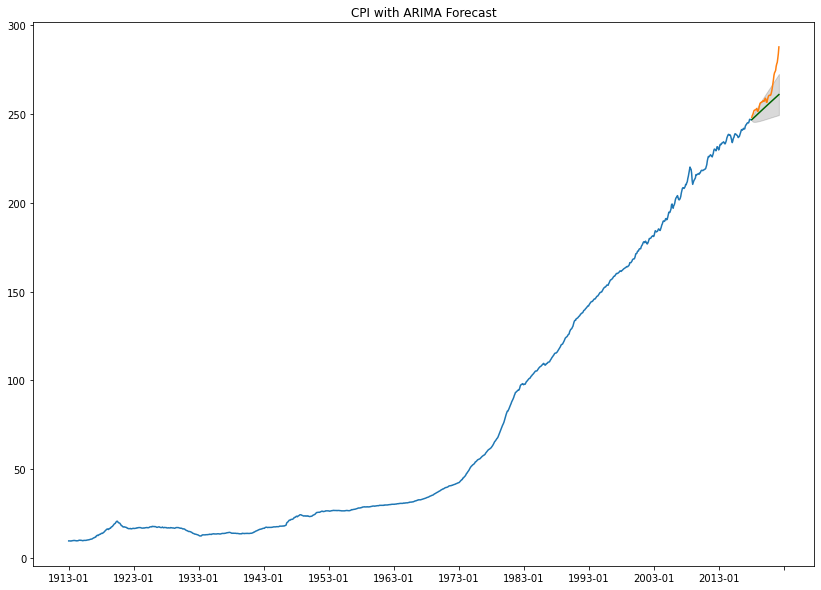

In [ ]:
# Forecast
n_periods = len(cpi_data[cpi_data['Date'] >= forecast_date])
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(cpi_data[cpi_data['Date'] < forecast_date]), len(cpi_data[cpi_data['Date'] < forecast_date])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(14, 10))
plt.xticks(np.arange(0, 10000, 120)) # show x-ticks every 10 years
plt.plot(cpi_data[cpi_data['Date'] < forecast_date]['Date'], cpi_data[cpi_data['Date'] < forecast_date]['Value'])
plt.plot(cpi_data[cpi_data['Date'] >= forecast_date]['Date'], cpi_data[cpi_data['Date'] >= forecast_date]['Value'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("CPI with ARIMA Forecast")
plt.show()

In [ ]:
# Calculate Accuracy
calc_acc(cpi_data[cpi_data['Date'] >= forecast_date][['Value']], fc_series)

Accuracy of Model = 96.6%
MSE = 0.5814913368385832


#### Conclusion from our CPI ARIMA Model

The actual values from our test dataset are in orange, while the values predicted by the ARIMA model are in green. It looks to be a decent predictor, usually remaining in the estimated grey range, with the exception of the post Covid-19 inflation spike. It also has a 97% accuracy after calculation of MAPE.

### Introducing Exogenous Variables Into the Forecast

Apart from using past values to predict future values of CPI, ARIMA also allows us to introduce exogenous variables. For our project, we can now introduce our other variables like CO2, PPI, unemployment, etc.

Let us first define a function to help us get the ARIMA models for CPI with a single exogenous variable each.

In [ ]:
def univariate_exogenous(var, forecast_date='2018', x_tick_interval=10000):
    model = pm.auto_arima(y=df_list[var][df_list[var]['Date'] < forecast_date][['Value_y']], start_p=1, start_q=1,
                        X=df_list[var][df_list[var]['Date'] < forecast_date][['Value_x']],
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=3, max_q=3, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0,
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

    # Forecast
    n_periods = len(df_list[var][df_list[var]['Date'] >= forecast_date])
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True, X=df_list[var][df_list[var]['Date'] >= forecast_date][['Value_x']]
    )
    index_of_fc = np.arange(len(df_list[var][df_list[var]['Date'] < forecast_date]), len(df_list[var][df_list[var]['Date'] < forecast_date])+n_periods)

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Calculate Accuracy
    calc_acc(df_list[var][df_list[var]['Date'] >= forecast_date][['Value_y']], fc_series)

    # Plot
    plt.figure(figsize=(14, 10))
    plt.xticks(np.arange(0, x_tick_interval, 120))
    plt.plot(df_list[var][df_list[var]['Date'] < forecast_date]['Date'], df_list[var][df_list[var]['Date'] < forecast_date]['Value_y'])
    plt.plot(df_list[var][df_list[var]['Date'] >= forecast_date]['Date'], df_list[var][df_list[var]['Date'] >= forecast_date]['Value_y'])
    plt.plot(fc_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title(f'CPI with ARIMA Forecast (Exogenous Variable: {var})')
    plt.show()

#### CPI ARIMA Model with Exogenous Variable of BIE

For datasets with data from before 2000, we shall forecast 5 years, and for dataset with data starting only after 2000, we shall forcast for 2 years.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=154.704, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=184.764, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=160.438, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=153.666, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=197.865, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=154.659, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=156.637, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=159.772, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.675 seconds
Accuracy of Model = 97.0%
MSE = 0.4478998154861453


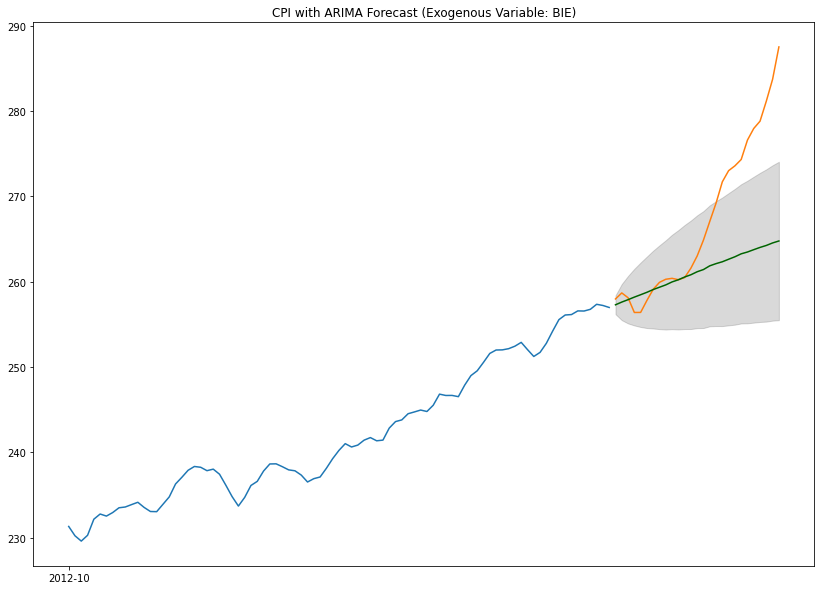

In [ ]:
univariate_exogenous('BIE', forecast_date='2020', x_tick_interval=1000)

#### CPI ARIMA Model with Exogenous Variable of Bitcoin Price

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=115.741, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134.131, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=118.459, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=114.344, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=144.411, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=116.334, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=117.583, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=116.668, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.163 seconds
Accuracy of Model = 96.9%
MSE = 0.5239778529352921


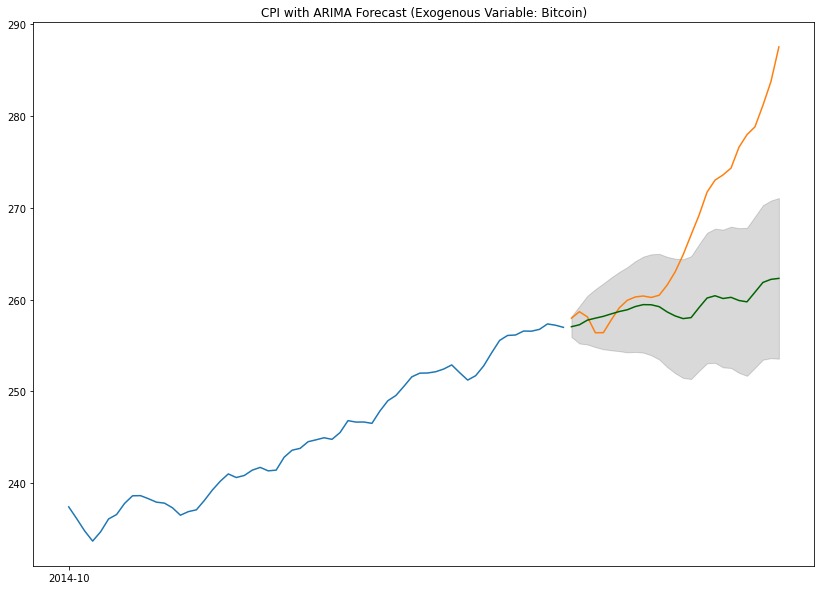

In [ ]:
univariate_exogenous('Bitcoin', forecast_date='2020', x_tick_interval=1000)

#### CPI ARIMA Model with Exogenous Variable of CO2

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=801.051, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1045.947, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=817.226, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=829.031, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1225.537, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=798.110, Time=1.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=796.698, Time=0.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=797.984, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=798.890, Time=1.84 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=866.767, Time=0.51 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 6.573 seconds
Accuracy of Model = 96.6%
MSE = 0.5682679574800891


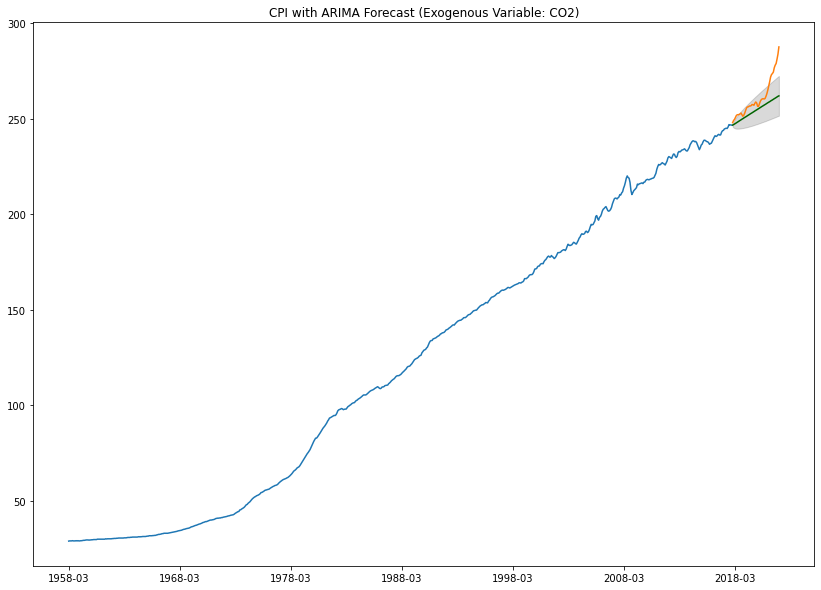

In [ ]:
univariate_exogenous('CO2', forecast_date='2018', x_tick_interval=10000)

#### CPI ARIMA Model with Exogenous Variable of NEER

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=531.075, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=605.057, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=541.209, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=533.839, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=673.778, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=515.170, Time=0.96 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=524.581, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=515.705, Time=2.34 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=515.658, Time=2.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=529.047, Time=0.57 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=523.980, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=517.642, Time=1.95 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=556.992, Time=0.26 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 10.215 seconds
Accuracy of Model = 96.6%
MSE = 0.

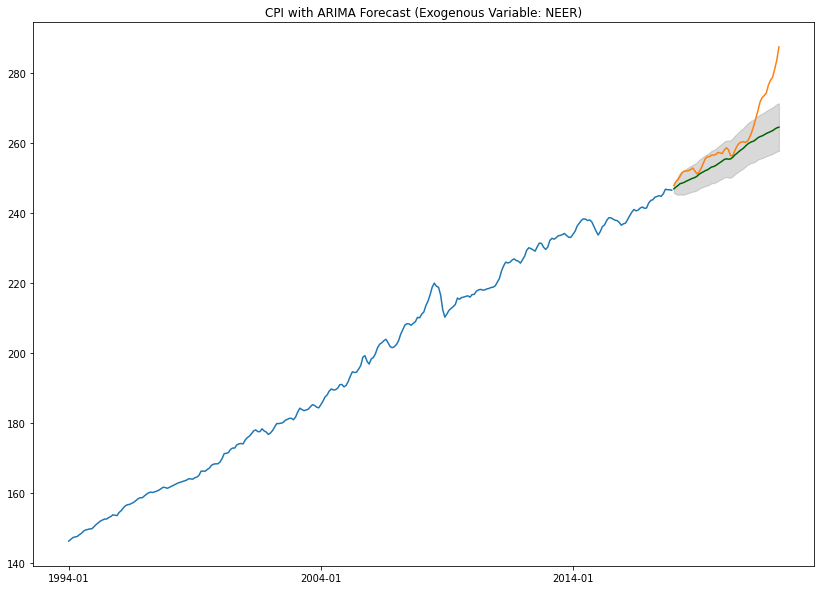

In [ ]:
univariate_exogenous('NEER', forecast_date='2018', x_tick_interval=10000)

#### CPI ARIMA Model with Exogenous Variable of Oil Price

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=654.800, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=718.242, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=665.335, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=660.052, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=852.074, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=638.796, Time=1.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=648.094, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=649.501, Time=0.61 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=651.445, Time=1.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=651.258, Time=0.88 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=647.273, Time=0.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=642.155, Time=1.98 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=699.234, Time=0.52 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 8.359 seconds
Accuracy of Model = 96.6%
MSE = 0.5

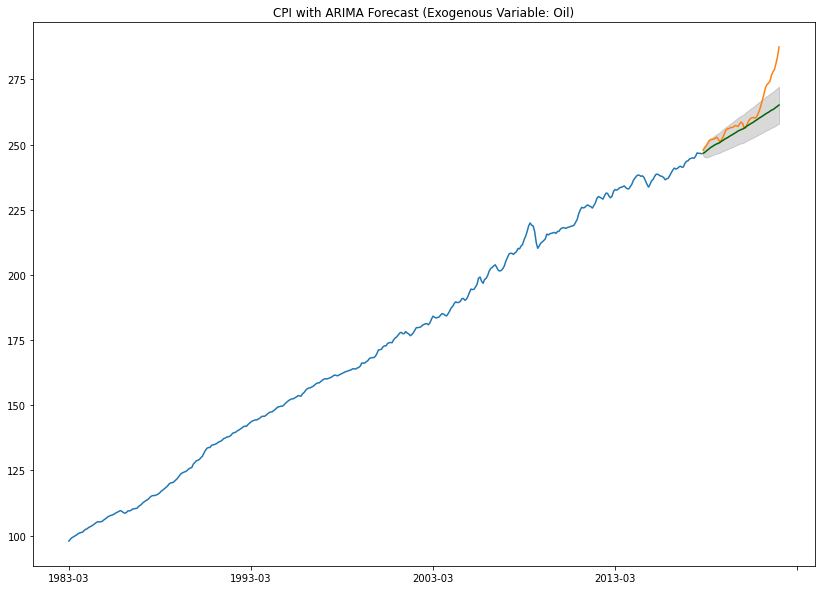

In [ ]:
univariate_exogenous('Oil', forecast_date='2018', x_tick_interval=10000)

#### CPI ARIMA Model with Exogenous Variable of PPI

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=89.572, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=371.707, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=89.858, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=135.079, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=651.235, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=91.507, Time=1.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-33.303, Time=3.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=83.881, Time=0.96 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-26.801, Time=3.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-20.470, Time=4.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=85.874, Time=1.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-30.694, Time=4.79 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-34.100, Time=2.63 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=213.295, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=181.195, T

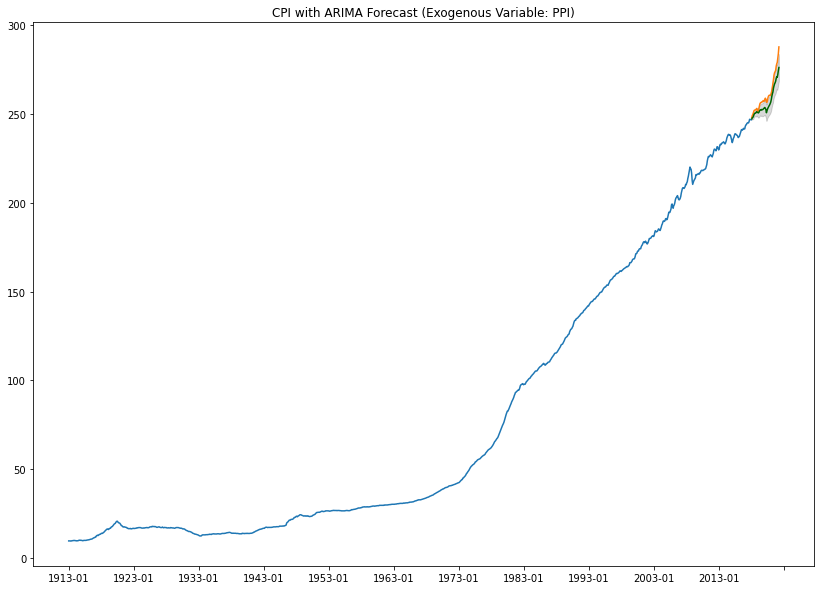

In [ ]:
univariate_exogenous('PPI', forecast_date='2018', x_tick_interval=10000)

#### CPI ARIMA Model with Exogenous Variable of S&P500

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=750.469, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=930.955, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=767.442, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=765.752, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1138.250, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=742.550, Time=2.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=744.435, Time=1.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=746.870, Time=2.73 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=749.506, Time=2.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=746.969, Time=1.84 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=744.746, Time=1.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=750.696, Time=2.47 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=825.308, Time=1.38 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 17.592 seconds
Accuracy of Model = 96.7%
MSE = 0

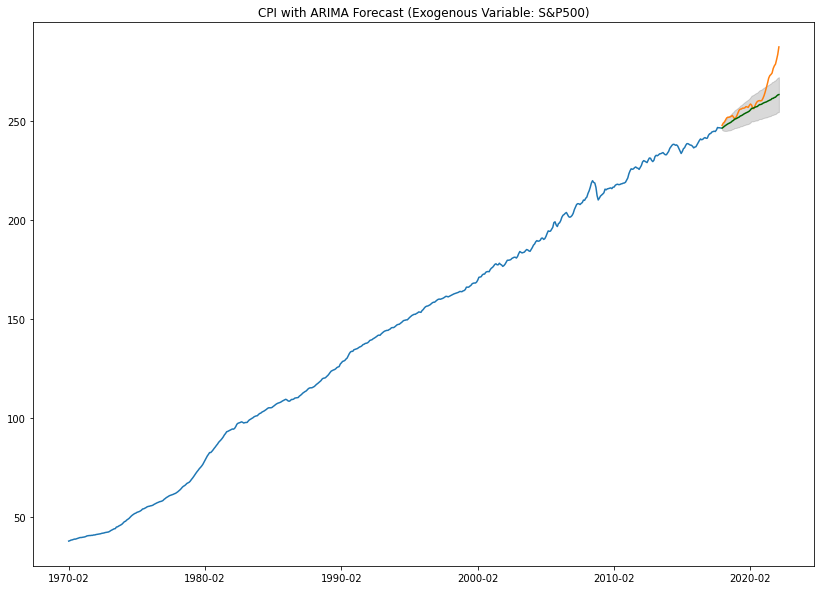

In [ ]:
univariate_exogenous('S&P500', forecast_date='2018', x_tick_interval=10000)

#### CPI ARIMA Model with Exogenous Variable of Unemployment Rate

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=825.145, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1133.523, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=843.262, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=865.220, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1360.769, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=823.726, Time=1.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=821.846, Time=0.56 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=823.679, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=825.049, Time=1.42 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=892.893, Time=0.79 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 6.613 seconds
Accuracy of Model = 97.1%
MSE = 0.39587084949472423


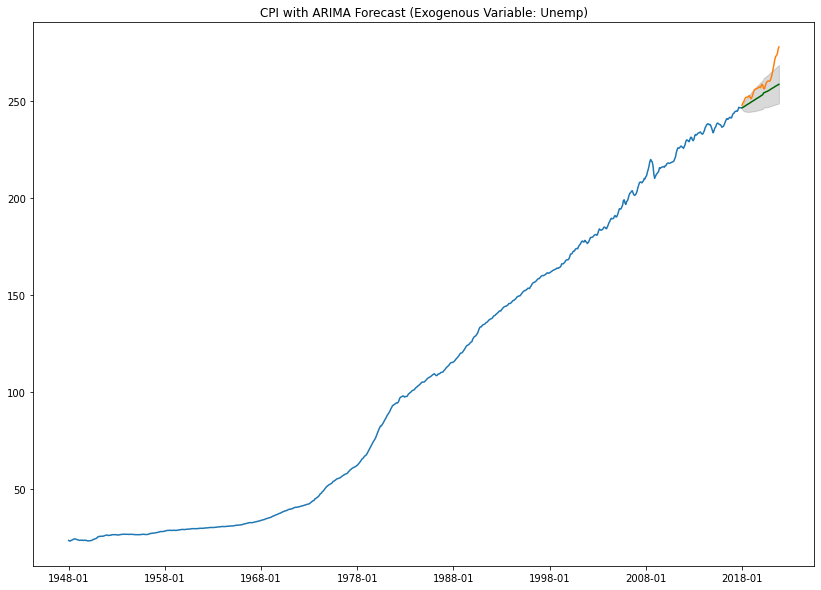

In [ ]:
univariate_exogenous('Unemp', forecast_date='2018', x_tick_interval=10000)

#### Conclusion from Single Exogenous Variable per ARIMA Model

Unemployment rate seems to be the best exogenous variable, with a highest accuracy of 97.1% and lowest MSE of 0.396. Next will be BIE, and then the rest of the variables with very similar accuracies and MSEs.

There is one interesting result, which is PPI as the exogenous variable. It has a lower accuracy and higher MSE than the CPI-only ARIMA model. However, when looking at the chart, the correlation actually looks closer. This seems to be because of a Covid-19 dip of PPI. As such, by observation, this PPI seems to be the best predictor. We will also observe this behaviour for our 8 exogenous factors model below, and this behaviour will be explained in more details below as well.

### Multi Exogenous Variables

Now let us try to combine the exogenous factors and see if we can create a better ARIMA model.

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=103.416, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=219.840, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=100.843, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=102.850, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=102.450, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=100.206, Time=0.40 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=104.130, Time=0.80 sec
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=134.612, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=175.913, Time=0

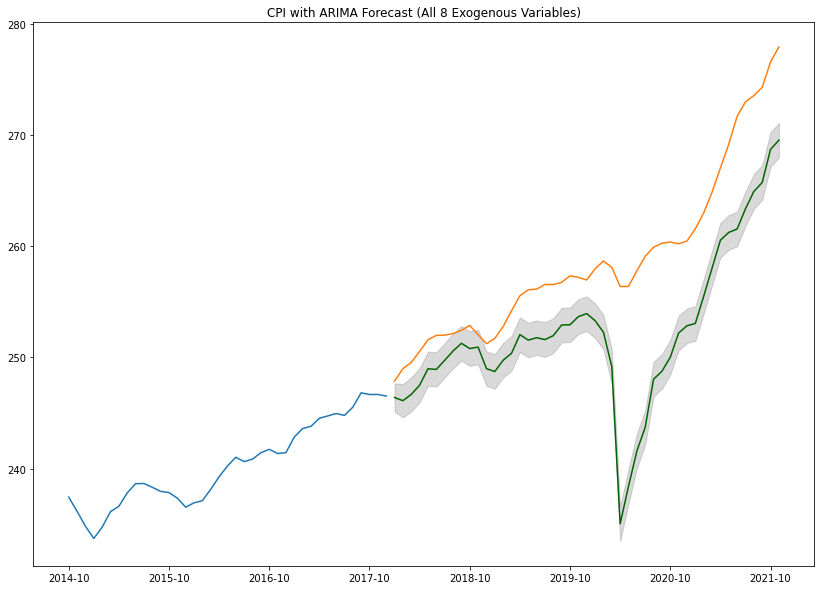

In [8]:
# Merge the values and plot a pairplot
dataset_list_values = {k:v[['Date', 'Value']] for (k,v) in dataset_list.items()}
dataset_list_values['CPI'] = cpi_data[['Date', 'Value']]
merged_values = reduce(lambda left,right: pd.merge(left,right,on='Date', how='inner'), dataset_list_values.values())
merged_values.columns = ['Date'] + list(dataset_list.keys()) + ['CPI']

forecast_date = '2018'
model = pm.auto_arima(y=merged_values[merged_values['Date'] < forecast_date][['CPI']], start_p=1, start_q=1,
                        X=merged_values[merged_values['Date'] < forecast_date][['BIE', 'Bitcoin', 'CO2', 'NEER', 'Oil', 'PPI', 'S&P500', 'Unemp']],
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=3, max_q=3, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0,
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

# Forecast
n_periods = len(merged_values[merged_values['Date'] >= forecast_date]['Date'])
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True, X=merged_values[merged_values['Date'] >= forecast_date][['BIE', 'Bitcoin', 'CO2', 'NEER', 'Oil', 'PPI', 'S&P500', 'Unemp']]
)
index_of_fc = np.arange(len(merged_values[merged_values['Date'] < forecast_date]['Date']), len(merged_values[merged_values['Date'] < forecast_date]['Date'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Calculate Accuracy
calc_acc(merged_values[merged_values['Date'] < forecast_date][['CPI']], fc_series)

# Plot
plt.figure(figsize=(14, 10))
plt.xticks(np.arange(0, 100, 12))
plt.plot(merged_values[merged_values['Date'] < forecast_date]['Date'], merged_values[merged_values['Date'] < forecast_date]['CPI'])
plt.plot(merged_values[merged_values['Date'] >= forecast_date]['Date'], merged_values[merged_values['Date'] >= forecast_date]['CPI'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)

plt.title(f'CPI with ARIMA Forecast (All 8 Exogenous Variables)')
plt.show()



#### Conclusion from Multi Exogenous Variable ARIMA Model

The accuracy is significantly lower and MSE significantly higher than the CPI-only ARIMA model, and all the ARIMA models with a single exogenous variable. This could mean overfitting, and hence, it seems that ARIMA is best used with a single exogenous variable, and in the case of CPI, that will be with a single variable of unemployment rates.

However, on closer analysis, this dip also seems to be a Covid-19 dip. As such, from observation, this model seems to be our most accurate model, as it is the only model which looks to follow the trend of the actual values (orange line) the most closely.

For our next LSTM model, we will observe a very similar behaviour as well.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=79877156-404b-4799-8878-ebdaab8d2638' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>